<a id = "Table_of_content"></a>
# Table of content
### 1. [Introduction](#Introduction)
### 2. [Data Preparation](#Data_Preparation)
#### &emsp;► [Import Images](#Import_Image)
#### &emsp;► [Data Normalization](#Data_Normalization)
#### &emsp;► [Split Data](#Train_test_split)
#### &emsp;► [Data Augmentation](#Data_Augmentation)
#### &emsp;► [Gaussian Filter](#Gaussian_Filter)
#### &emsp;► [Data Preprocessing on Test Dataset](#Test_Data_Preprocessing)
#### &emsp;► [Convert Data to Pytorch Tensor and Fit Into DataLoader](#Numpy_to_Tensor)
### 3. [Model Architecture](#Model_Architecture)
#### &emsp;► [Convolutional Neural Network](#Convolutional_Neural_Network)
#### &emsp;► [Model Training and Validation Using Two Different Optimizer (Adam and SGD)](#Train_Model)
#### &emsp;► [Hyperparameter Tuning on Learning Rate, and Weight Decay](#Hyperparameter_Tuning)
#### &emsp;► [Model Testing](#Model_Testing)
#### &emsp;► [Experiment Using PreTrained Network (ResNet18)](#Experiment1)
#### &emsp;► [Experiment Using Dataset with Two Class](#Experiment2)

<a id = "Introduction"></a></a><div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Introduction

As Artificial Intelligence garnering attention, deep learning is being emphasized more than typical machine learning methods by researchers as it has more potential in terms of performance and usage. In this project, our objective is to implement deep learning models to detect and identify hand gestures for 1 to 5. 

<a id = "Data_Preparation"></a> <div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Data Preparation 

In [1]:
# Import library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import numpy as np
from sklearn.model_selection import train_test_split
from skimage import io
from skimage.transform import resize, rotate # For data augmentation
from skimage.util import random_noise # For data augmentation
import cv2 # To perform gaussian low pass filter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
import glob
import os
from tqdm import tqdm
import copy

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<a id = "Import_Image"></a>
### ► Import Images

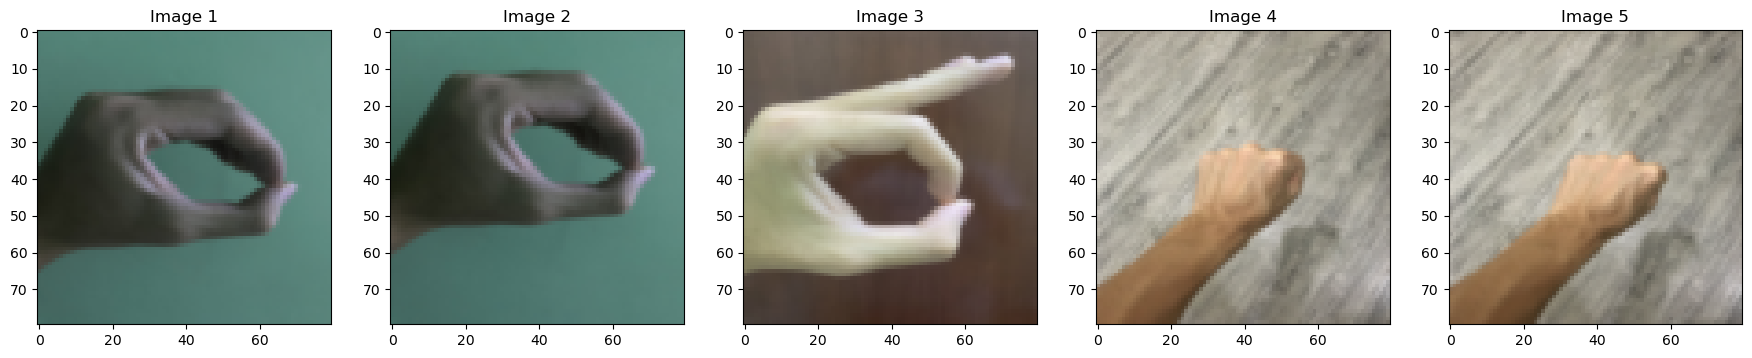

In [3]:
# Load image data
Images = []
Labels = []
k = 0
_, ax = plt.subplots(1, 5, figsize = (22,4))

# Visualize some examples of resize image
for i in glob.glob(r"Dataset\*"):
    imagei = io.imread(i)
    image_resized = resize(imagei, output_shape = (80, 80)) # resize image to shape of (80,80)
    Images.append(image_resized)
    Labels.append(int(os.path.basename(i).split("_")[0])) # get labels from filename
    
    # Visualize 5 of them
    if k < 5:
        ax[k].imshow(image_resized, cmap = 'gray')
        ax[k].set_title(f"Image {k+1}")
        k += 1

In [4]:
# Convert images and labels to array
D = np.array(Images).astype('float32')
y = np.array(Labels).astype('float32')

In [5]:
# Check size of data
print("Size of X:", D.shape)
print("Size of y:", y.shape)

Size of X: (2502, 80, 80, 3)
Size of y: (2502,)


Our dataset consist of mostly consistent data; however, we also included some noise image in order to increase the robustness of the deep learning model we trained latter. 

The noise data here included the following:
1. Unusual Hand gesture. For example: Using thumb or little finger to gesture '1' instead of common gesture using index finger.
2. Image that has complex background image which is noise

The part below shows some examples of dataset images

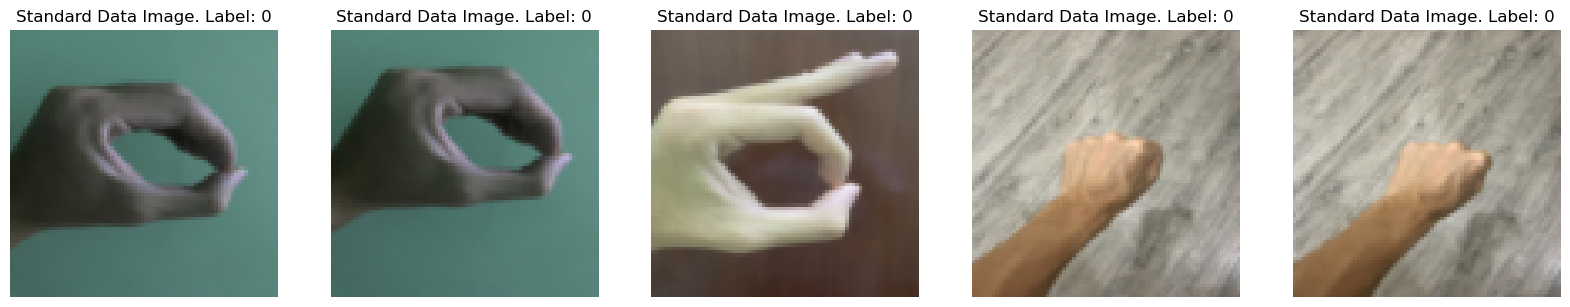

In [6]:
# Visualize some image examples of dataset
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(5):
    ax[i].imshow(D[i])
    ax[i].set_title('Standard Data Image. Label: 0')
    ax[i].axis('off')

<a id = "Data_Normalization"></a>
### ► Data Normalization

In [7]:
# Normalize image pixels to 0-1
def normalize_images(images):
    
    normalized_images = np.zeros_like(images.astype('float32'))
    num_images = images.shape[0]
    max_val, min_val = images.max(), images.min()
    
    for img in range(num_images):
        normalized_images[img, ...] = (images[img, ...] - float(min_val)) / float(max_val - min_val)
    
    return normalized_images

In [8]:
D = normalize_images(D)

<a id = "Train_test_split"></a>
### ► Split Data

Our dataset is first split into **80% training dataset, 20% testing dataset**. As deep learning model we choose might have a number of hyperparameters to tune, **the training dataset is split again with a 80/20 ratio to generate validation dataset.**

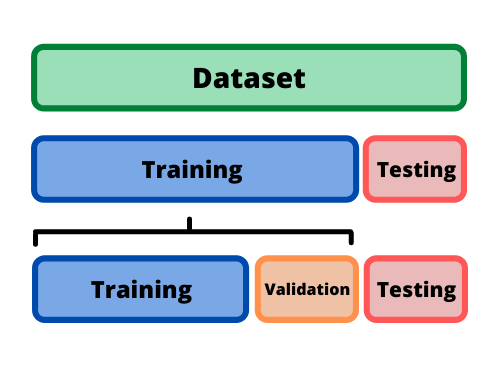

In [9]:
# split data into train and test set
X, x_test, Y, y_test = train_test_split(D, y, test_size = 0.2, shuffle = True)
print("After seperate to 80% training and 20% test, X_train have shape",X.shape,"y_train have shape",Y.shape)
print("                                             X_test  have shape",x_test.shape,"y_test have shape",y_test.shape)

After seperate to 80% training and 20% test, X_train have shape (2001, 80, 80, 3) y_train have shape (2001,)
                                             X_test  have shape (501, 80, 80, 3) y_test have shape (501,)


In [10]:
#Visualize the content count of the train dataset
unique, counts = np.unique(Y, return_counts = True)
dict(zip(unique, counts))

{0.0: 329, 1.0: 336, 2.0: 355, 3.0: 328, 4.0: 326, 5.0: 327}

In [11]:
#Visualize the content count of the test dataset
unique, counts = np.unique(y_test, return_counts = True)
dict(zip(unique, counts))

{0.0: 83, 1.0: 76, 2.0: 73, 3.0: 94, 4.0: 88, 5.0: 87}

<a id = "Data_Augmentation"></a>
### ► Data Augmentation

In order to achieve better accuracy for classification, the model have to train on a huge dataset which consist of huge number of images. As for our project, our dataset are manually constructed; it will be a hassle in collecting thousands of images. Thus in order to obtain large dataset, we augment our data by the following three choices: **rotating, flipping and adding some noise into the original images.**

In [12]:
# Data augmentation (image augmentation on training dataset)
# Generate 4 augmented images for each 1664 images in training dataset
train_data = []
target_train = []

for i in tqdm(range(X.shape[0])):
    train_data.append(X[i]) # Original image
    # Randomly choose 1 option to augment the data, we do augmentation only once on every image
    a = np.random.randint(0,4)
    if a == 0:
        train_data.append(rotate(X[i], angle = 15, mode = 'wrap')) # Rotate the image by 15 degrees
    elif a == 1:
        train_data.append(np.fliplr(X[i])) # Flip image in left-right direction
    elif a == 2:
        train_data.append(np.flipud(X[i])) # Flip image in up-down direction
    elif a == 3:
        train_data.append(random_noise(X[i], var = 0.2 ** 2)) # Add random noise to the floating-point image
    
    for j in range(2):
        target_train.append(Y[i]) # Label the augmented images

100%|██████████| 2001/2001 [00:00<00:00, 2615.72it/s]


In [13]:
# Check number of images after augmentation
print("Number of data in train dataset after image augmentation:\n")
print("Number of images:", len(train_data))
print("Number of labels:", len(target_train))

Number of data in train dataset after image augmentation:

Number of images: 4002
Number of labels: 4002


In [14]:
# Convert images and labels to array
train_data = np.array(train_data).astype('float32')
target_train = np.array(target_train).astype(int)

In [15]:
# Visualize some image in dataset after augmentation
def show_img(index):
    fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (10,10))
    for i in range(5):
        ax[i].imshow(train_data[i + index], cmap = 'gray')
        ax[i].axis('off')

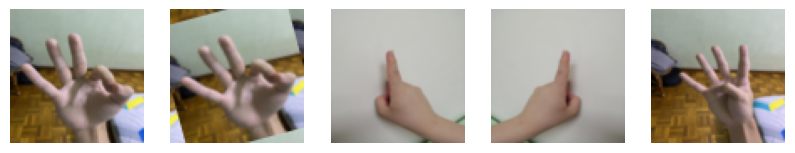

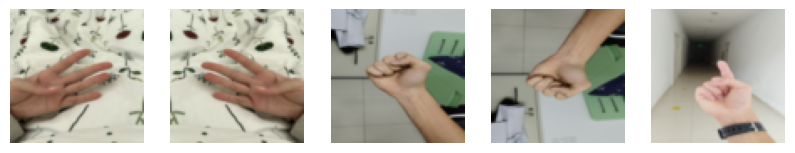

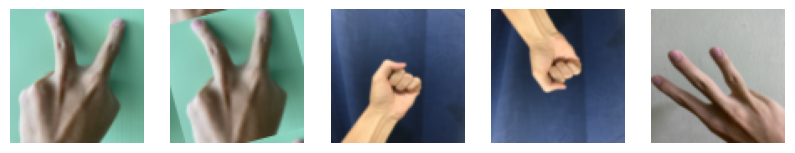

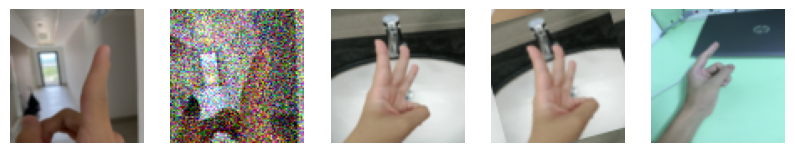

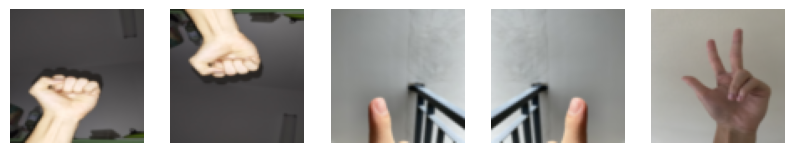

In [16]:
show_img(10)
show_img(500)
show_img(100)
show_img(200)
show_img(600)

<a id = "Gaussian_Filter"></a>
### ► Gaussian Filter

Gaussian filter is a method to blur and remove noise from images. The mathematical equation is as below. **$x$ is the X-coordinate value; $y$ is the Y-coordinate value; $\pi$ is Mathematical constant (3.142..); $e$ is Mathematical constant (2.718..) and $\sigma$ is the standard deviation.** 

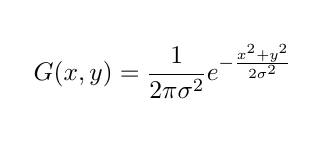

A gaussian kernel approximation of size 3x3 with **standard deviation of 1** is used. 

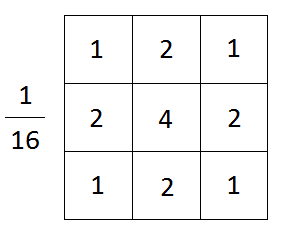

In [17]:
gaussian_blured = []
for i in tqdm(range(train_data.shape[0])):
    gaussian_blured.append(cv2.GaussianBlur(train_data[i], (3,3), 0))

100%|██████████| 4002/4002 [00:00<00:00, 25614.44it/s]


In [18]:
train_data = np.array(gaussian_blured).astype('float32')

In [19]:
# Check shape of dataset after denoising using gaussian low pass filter
print("After performing gaussian filter, the shape of train dataset is:", train_data.shape)

After performing gaussian filter, the shape of train dataset is: (4002, 80, 80, 3)


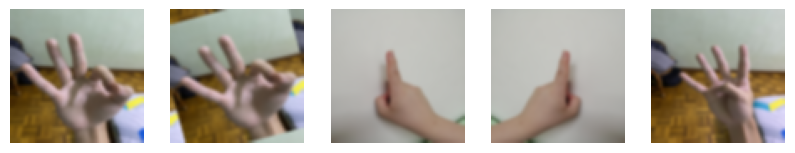

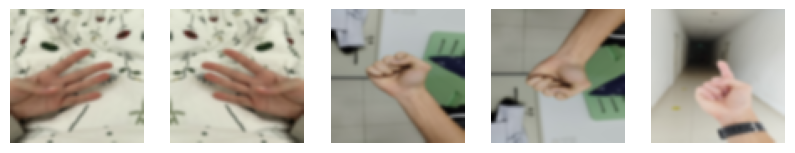

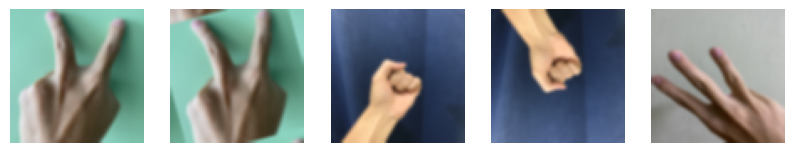

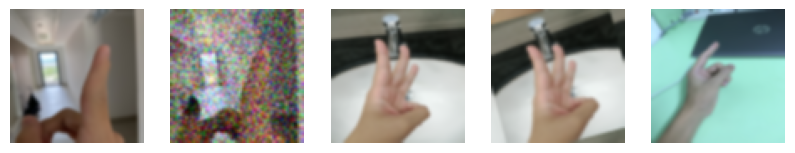

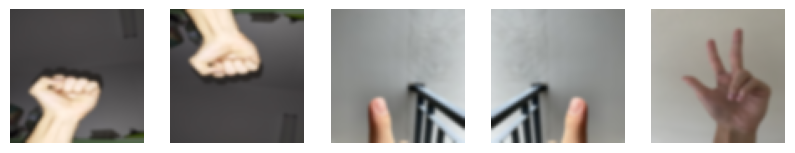

In [20]:
show_img(10)
show_img(500)
show_img(100)
show_img(200)
show_img(600)

In [21]:
# Split train_data to training data and validation data
x_train, x_valid, y_train, y_valid = train_test_split(train_data, target_train, test_size = 0.3, shuffle = True)
print("After seperate to 80% training and 20% validation, X_train have shape",x_train.shape,"y_train have shape",y_train.shape)
print("                                                   X_valid have shape",x_valid.shape,"y_valid have shape",y_valid.shape)

After seperate to 80% training and 20% validation, X_train have shape (2801, 80, 80, 3) y_train have shape (2801,)
                                                   X_valid have shape (1201, 80, 80, 3) y_valid have shape (1201,)


In [22]:
# Transpose the data from shape (80,80,3) to (3,80,80)
temp = []
for i in tqdm(range(x_train.shape[0])):
    temp.append(x_train[i].T)

# Convert data to numpy array
x_train = np.array(temp)

100%|██████████| 2801/2801 [00:00<00:00, 1165384.93it/s]


In [23]:
# Transpose the data from shape (80,80,3) to (3,80,80)
temp = []
for i in tqdm(range(x_valid.shape[0])):
    temp.append(x_valid[i].T)

# COnvert data to numpy array
x_valid = np.array(temp)

100%|██████████| 1201/1201 [00:00<?, ?it/s]


In [24]:
# Check final shape of train and validation data
print("After transpose the data, X_train have shape",x_train.shape)
print("                          X_valid have shape",x_valid.shape)

After transpose the data, X_train have shape (2801, 3, 80, 80)
                          X_valid have shape (1201, 3, 80, 80)


<a id = "Test_Data_Preprocessing"></a>
### ► Data Preprocessing on Test Dataset

In [25]:
gaussian_blured = []
for i in tqdm(range(x_test.shape[0])):
    gaussian_blured.append(cv2.GaussianBlur(x_test[i], (3,3), 0))

100%|██████████| 501/501 [00:00<00:00, 17917.35it/s]


In [26]:
# Convert test dataset to numpy array
x_test = np.array(gaussian_blured).astype('float32')

In [27]:
# Transpose the data from shape (80,80,3) to (3,80,80)
temp = []
for i in tqdm(range(x_test.shape[0])):
    temp.append(x_test[i].T)
    
# Convert data to numpy array
x_test = np.array(temp).astype('float32')

# Check shape of test dataset after denoising using gaussian low pass filter
print("After performing gaussian filter, the shape of test dataset is:", x_test.shape)

100%|██████████| 501/501 [00:00<00:00, 1000641.10it/s]

After performing gaussian filter, the shape of test dataset is: (501, 3, 80, 80)


<a id = "Numpy_to_Tensor"></a>
### ► Convert Data to PyTorch Tensor and Fit Into DataLoader

In [28]:
# Convert train, validation, and test dataset into pyTorch format

# Converting train dataset into torch format
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
y_train = y_train.long()

# Converting validation dataset into torch format
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid)
y_valid = y_valid.long()

# Converting test dataset into torch format
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
y_test = y_test.long()

In [29]:
# Check format of all datasets
print("Type of train image dataset:", type(x_train))
print("Type of train label dataset:", type(y_train))
print("Type of validation image dataset:", type(x_valid))
print("Type of validation label dataset:", type(y_valid))
print("Type of test image dataset:", type(x_test))
print("Type of test label dataset:", type(y_test))

# Check len of all datasets
print("\nNumber of train dataset:", len(x_train))
print("Number of validation dataset:", len(x_valid))
print("Number of test dataset:", len(x_test))

# Check size of all datasets
print("\nShape of train image dataset:", x_train.shape)
print("Shape of validation image dataset:", x_valid.shape)
print("Shape of test image dataset:", x_test.shape)

Type of train image dataset: <class 'torch.Tensor'>
Type of train label dataset: <class 'torch.Tensor'>
Type of validation image dataset: <class 'torch.Tensor'>
Type of validation label dataset: <class 'torch.Tensor'>
Type of test image dataset: <class 'torch.Tensor'>
Type of test label dataset: <class 'torch.Tensor'>

Number of train dataset: 2801
Number of validation dataset: 1201
Number of test dataset: 501

Shape of train image dataset: torch.Size([2801, 3, 80, 80])
Shape of validation image dataset: torch.Size([1201, 3, 80, 80])
Shape of test image dataset: torch.Size([501, 3, 80, 80])


In [30]:
# Fit data into torch dataset
train_dataset = TensorDataset(x_train, y_train)
validation_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

In [31]:
# DataLoader
train_loader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True, drop_last = True)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 4, shuffle = True, drop_last = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 4, shuffle = False)

<a id = "Model_Architecture"></a> <div style="text-align: right"> <a href=#Table_of_content>Back?</a> </div>
# Model Architecture

<a id = "Convolutional_Neural_Network"></a>
### ► Convolutional Neural Network

In [32]:
class Net(nn.Module):
    
    def __init__(self, num_classes = 6):
        
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.drop = nn.Dropout2d(p = 0.5)
        self.fc1 = nn.Linear(in_features = 24 * 10 * 10, out_features = 240)
        self.fc2 = nn.Linear(in_features = 240, out_features = num_classes)
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = x.view(-1, 24 * 10 * 10)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
        

In [33]:
# Print summary of CNN model
model = Net().to(device)
summary(model, (3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 80, 80]             168
         MaxPool2d-2            [-1, 6, 40, 40]               0
         Dropout2d-3            [-1, 6, 40, 40]               0
            Conv2d-4           [-1, 12, 40, 40]             660
         MaxPool2d-5           [-1, 12, 20, 20]               0
         Dropout2d-6           [-1, 12, 20, 20]               0
            Conv2d-7           [-1, 24, 20, 20]           2,616
         MaxPool2d-8           [-1, 24, 10, 10]               0
         Dropout2d-9           [-1, 24, 10, 10]               0
           Linear-10                  [-1, 240]         576,240
           Linear-11                    [-1, 6]           1,446
Total params: 581,130
Trainable params: 581,130
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.07
Forward/

<a id = "Train_Model"></a>
### ► Model Training and Validation Using Two Different Optimizer (Adam and SGD)

In this section, we will try to investigate which optimizer suit our network and dataste. The choices of optimizer is Adam Optimizer and SGD Optimizer.

In [34]:
# Function for model training and validation
def train_with_val(model, criterion, optimizer, num_epochs):
    
    counter = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to high value first
    best_loss = 2.0
    best_val_loss = 2.0
    best_train_loss = 2.0
    best_acc = 0.0
    
    loss_history = []
    correct_history = []
    valid_loss_history = []
    valid_correct_history = []
    
    for epoch in range(num_epochs):
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print('-------------------------------')
        train_loss = 0.0
        correct = 0.0      
        model.train()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_loss += loss.item()
            correct += (preds == labels).sum()
            
        # calculate training loss and accuracy    
        epoch_train_loss = train_loss / len(x_train)
        epoch_train_acc = (100.0 * correct / len(x_train)).item()
        loss_history.append(epoch_train_loss)
        correct_history.append(epoch_train_acc)

        valid_loss = 0.0
        valid_correct = 0.0
        model.eval() # set model to evaluation mode
        
        with torch.no_grad():
            for val_images, val_labels in validation_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                valid_loss += val_loss.item()
                valid_correct += (val_preds == val_labels).sum()
                
        # calculate validation loss and accuracy
        epoch_val_loss = valid_loss / len(x_valid)
        epoch_val_acc = (100.0 * valid_correct / len(x_valid)).item()
        valid_loss_history.append(epoch_val_loss)
        valid_correct_history.append(epoch_val_acc)

        print(f'Training Loss: {epoch_train_loss:.4f}, Accuracy: {epoch_train_acc:.4f} \nValidation Loss: {epoch_val_loss:.4f}, Accuracy: {epoch_val_acc:.4f}')
        
        # if validation loss is improve from previous epoch, save the model
        if epoch_val_loss < best_loss:
            
            print(f'\nValidation Loss Decrease from {best_loss:.4f} to {epoch_val_loss:.4f} \t Model is Saved\n')
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc # update the best validation accuracy
            
        
        # Perform early stopping to prevent overfitting, here we set the patience as 5
        
        if epoch_train_loss < best_train_loss:
            best_train_loss = epoch_train_loss
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
        
        if epoch_val_loss < epoch_train_loss and epoch_val_loss > best_val_loss:
            counter += 1
        else:
            counter = 0
        
        if counter == 5: # 5 patience is given before early stopping
            print("We are at epoch:", epoch)
            break # to terminate out the training loop
    
    # Plotting graphs for loss and accuracy
    plt.plot(loss_history,label='Training Loss')  
    plt.plot(valid_loss_history,label='Validation Loss')  
    plt.legend()  
    plt.show()  
    plt.plot(correct_history,label='Training accuracy')  
    plt.plot(valid_correct_history,label='Validation accuracy')  
    plt.legend()  
    plt.show()  
    
    # return the model with the highest validation accuracy
    model.load_state_dict(best_model_wts)
    return (model, best_acc, best_loss, valid_loss_history, valid_correct_history)

In [35]:
criterion = nn.CrossEntropyLoss()

Training on Adam optimizer:
Epoch [1/40]
-------------------------------
Training Loss: 0.4485, Accuracy: 17.0296 
Validation Loss: 0.4474, Accuracy: 17.4854

Validation Loss Decrease from 2.0000 to 0.4474 	 Model is Saved

Epoch [2/40]
-------------------------------
Training Loss: 0.4476, Accuracy: 18.4220 
Validation Loss: 0.4472, Accuracy: 19.9001

Validation Loss Decrease from 0.4474 to 0.4472 	 Model is Saved

Epoch [3/40]
-------------------------------
Training Loss: 0.4476, Accuracy: 17.8151 
Validation Loss: 0.4464, Accuracy: 21.8984

Validation Loss Decrease from 0.4472 to 0.4464 	 Model is Saved

Epoch [4/40]
-------------------------------
Training Loss: 0.4460, Accuracy: 18.7790 
Validation Loss: 0.4449, Accuracy: 24.7294

Validation Loss Decrease from 0.4464 to 0.4449 	 Model is Saved

Epoch [5/40]
-------------------------------
Training Loss: 0.4418, Accuracy: 22.3135 
Validation Loss: 0.4413, Accuracy: 17.9017

Validation Loss Decrease from 0.4449 to 0.4413 	 Model is

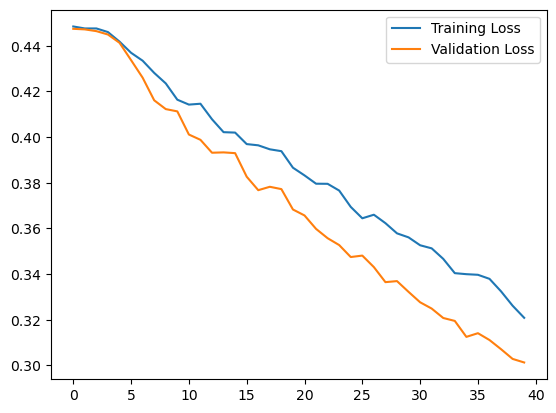

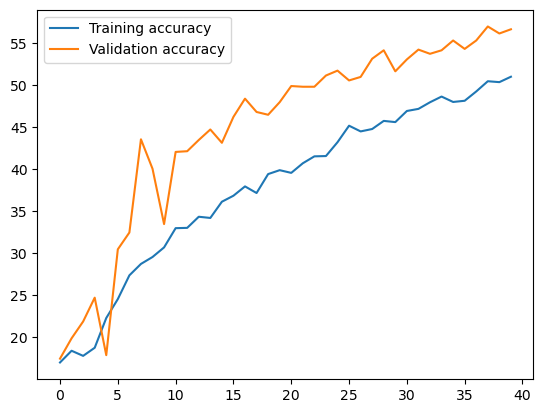

In [37]:
print(f'Training on Adam optimizer:')
model = Net().to(device)
adam = optim.Adam(model.parameters(), lr = 0.0001)
model_Adam, acc_Adam, loss_Adam, loss_history_Adam, acc_history_Adam = train_with_val(model, criterion, optimizer=adam, num_epochs=40)

Training on SGD optimizer:
Epoch [1/40]
-------------------------------
Training Loss: 0.4482, Accuracy: 16.2085 
Validation Loss: 0.4477, Accuracy: 16.0699

Validation Loss Decrease from 2.0000 to 0.4477 	 Model is Saved

Epoch [2/40]
-------------------------------
Training Loss: 0.4476, Accuracy: 16.1728 
Validation Loss: 0.4476, Accuracy: 16.0699

Validation Loss Decrease from 0.4477 to 0.4476 	 Model is Saved

Epoch [3/40]
-------------------------------
Training Loss: 0.4477, Accuracy: 16.8868 
Validation Loss: 0.4476, Accuracy: 16.9858

Validation Loss Decrease from 0.4476 to 0.4476 	 Model is Saved

Epoch [4/40]
-------------------------------
Training Loss: 0.4477, Accuracy: 16.7083 
Validation Loss: 0.4476, Accuracy: 17.6520
Epoch [5/40]
-------------------------------
Training Loss: 0.4474, Accuracy: 17.7794 
Validation Loss: 0.4475, Accuracy: 17.7352

Validation Loss Decrease from 0.4476 to 0.4475 	 Model is Saved

Epoch [6/40]
-------------------------------
Training Loss:

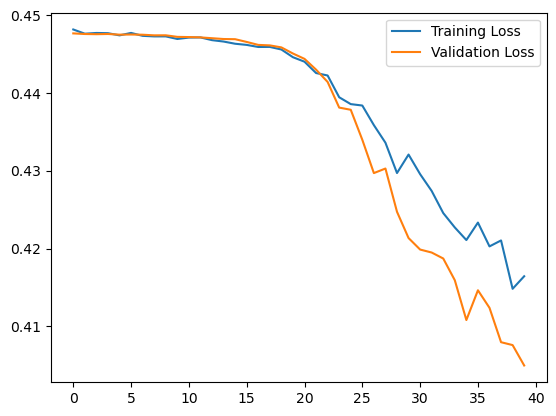

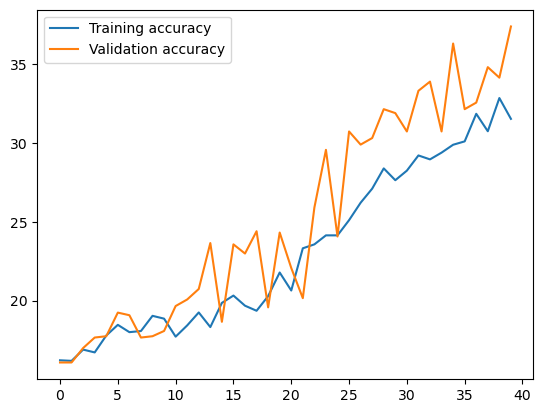

In [39]:
print(f'Training on SGD optimizer:')
model = Net().to(device)
sgd = optim.SGD(model.parameters(), lr = 0.001)
model_SGD, acc_SGD, loss_SGD, loss_history_SGD, acc_history_SGD = train_with_val(model, criterion, optimizer=sgd, num_epochs=40)

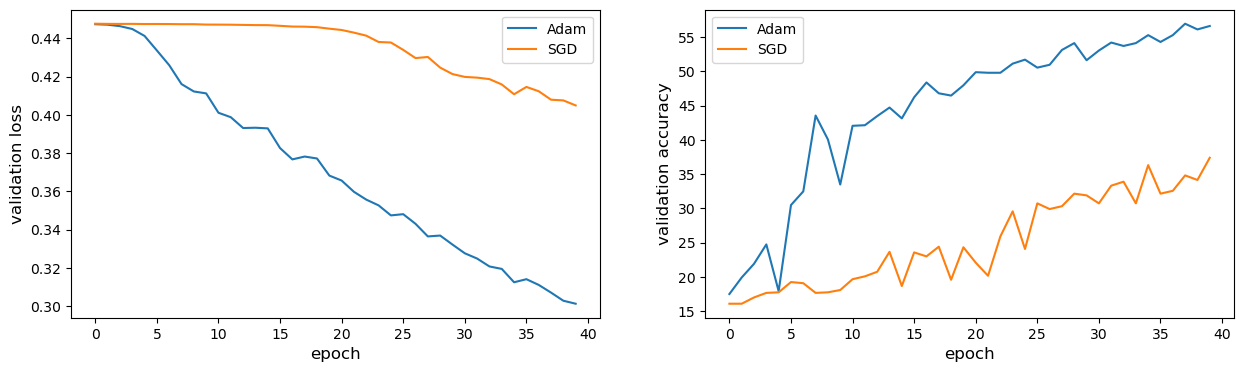

In [41]:
# Compare both Adam and SGD Optimizer
_, ax = plt.subplots(1, 2, figsize = (15,4))

ax[0].plot(loss_history_Adam, label = 'Adam')
ax[0].plot(loss_history_SGD, label = 'SGD')
ax[0].set_xlabel('epoch', fontsize = 12)
ax[0].set_ylabel('validation loss', fontsize = 12)
ax[0].legend()

ax[1].plot(acc_history_Adam, label = 'Adam')
ax[1].plot(acc_history_SGD, label = 'SGD')
ax[1].set_xlabel('epoch', fontsize = 12)
ax[1].set_ylabel('validation accuracy', fontsize = 12)
ax[1].legend()

In [42]:
# Check which is the best optimizer
if acc_Adam > acc_SGD:
    print("Adam Optimizer has better performance than SGD Optimizer with validation accuracy of: ", acc_Adam, "% and validation loss of:", loss_Adam, ' after 40 epochs')
else:
    print("SGD Optimizer has better performance than Adam Optimizer with validation accuracy of: ", acc_SGD, "% and validation loss of:", loss_SGD, " after 40 epochs")

Adam Optimizer has better performance than SGD Optimizer with validation accuracy of:  56.952537536621094 % and validation loss of: 0.3013033571588705  after 40 epochs


The results above shows that Adam Optimizer is way better than SGD Optimzer. Therefore, we will be using Adam Optimizer as our final model optimizer.

<a id = "Hyperparameter_Tuning"></a>
### ► Hyperparameter Tuning on Learning Rate, and Weight Decay Rate

In this section, we will perform **hyperparameter tuning on learning rate, and weight decay** in order to find our the best combination of hyperparameters. The method we used for hyperparameter tuning is Grid Search.

Training on cuda:0, Learning rate: 0.0001, Weight Decay: 0
Epoch [1/50]
-------------------------------
Training Loss: 0.4484, Accuracy: 16.5298 
Validation Loss: 0.4476, Accuracy: 15.2373

Validation Loss Decrease from 2.0000 to 0.4476 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4477, Accuracy: 18.1007 
Validation Loss: 0.4464, Accuracy: 25.3955

Validation Loss Decrease from 0.4476 to 0.4464 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4464, Accuracy: 18.1721 
Validation Loss: 0.4452, Accuracy: 27.8934

Validation Loss Decrease from 0.4464 to 0.4452 	 Model is Saved

Epoch [4/50]
-------------------------------
Training Loss: 0.4456, Accuracy: 20.5284 
Validation Loss: 0.4432, Accuracy: 24.8959

Validation Loss Decrease from 0.4452 to 0.4432 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4419, Accuracy: 20.6355 
Validation Loss: 0.4397, Accuracy: 25.3122

Validation Loss Decrease f

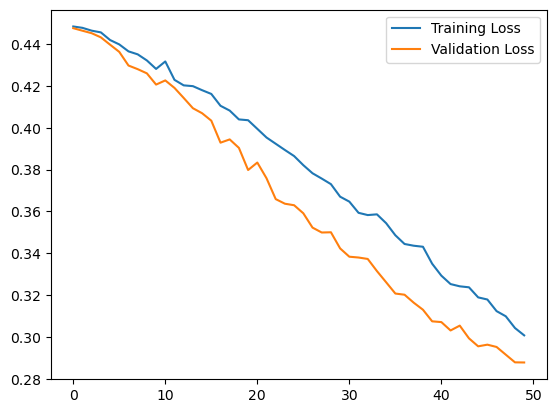

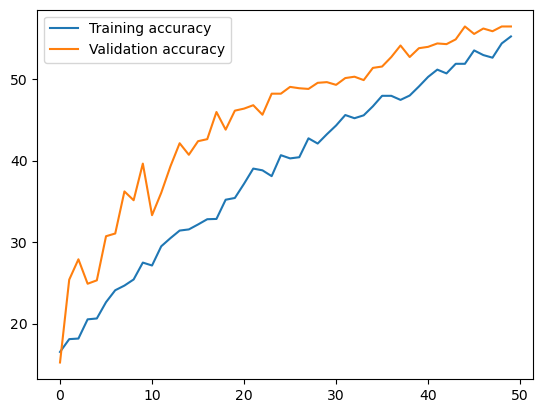

Training on cuda:0, Learning rate: 0.0001, Weight Decay: 0.0001
Epoch [1/50]
-------------------------------
Training Loss: 0.4480, Accuracy: 16.9225 
Validation Loss: 0.4475, Accuracy: 17.5687

Validation Loss Decrease from 2.0000 to 0.4475 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4480, Accuracy: 16.8154 
Validation Loss: 0.4474, Accuracy: 17.5687

Validation Loss Decrease from 0.4475 to 0.4474 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 17.7437 
Validation Loss: 0.4474, Accuracy: 17.5687

Validation Loss Decrease from 0.4474 to 0.4474 	 Model is Saved

Epoch [4/50]
-------------------------------
Training Loss: 0.4477, Accuracy: 17.4223 
Validation Loss: 0.4471, Accuracy: 18.1515

Validation Loss Decrease from 0.4474 to 0.4471 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4476, Accuracy: 18.7076 
Validation Loss: 0.4469, Accuracy: 17.5687

Validation Loss Decre

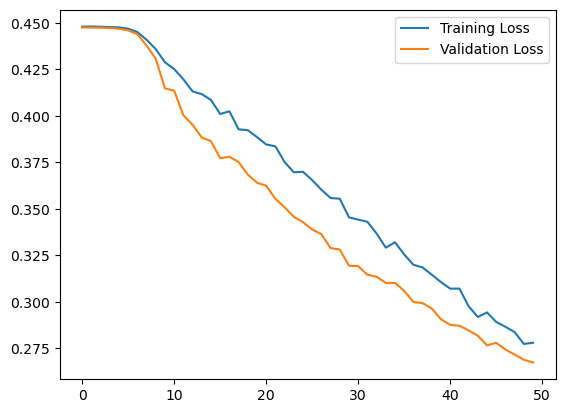

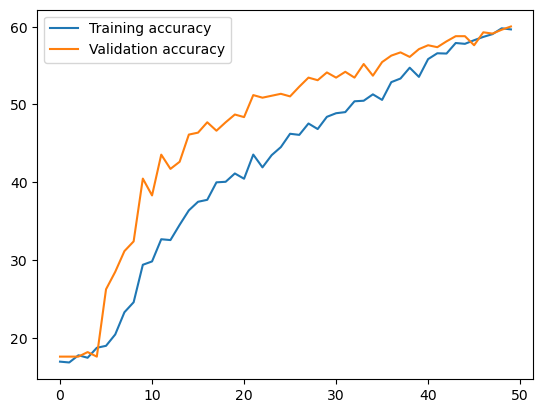

Training on cuda:0, Learning rate: 0.0001, Weight Decay: 0.0005
Epoch [1/50]
-------------------------------
Training Loss: 0.4484, Accuracy: 15.8158 
Validation Loss: 0.4469, Accuracy: 17.5687

Validation Loss Decrease from 2.0000 to 0.4469 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4469, Accuracy: 17.1724 
Validation Loss: 0.4461, Accuracy: 22.8976

Validation Loss Decrease from 0.4469 to 0.4461 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4436, Accuracy: 20.7783 
Validation Loss: 0.4343, Accuracy: 31.8068

Validation Loss Decrease from 0.4461 to 0.4343 	 Model is Saved

Epoch [4/50]
-------------------------------
Training Loss: 0.4333, Accuracy: 27.3831 
Validation Loss: 0.4216, Accuracy: 30.3081

Validation Loss Decrease from 0.4343 to 0.4216 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4246, Accuracy: 30.5962 
Validation Loss: 0.4102, Accuracy: 35.3039

Validation Loss Decre

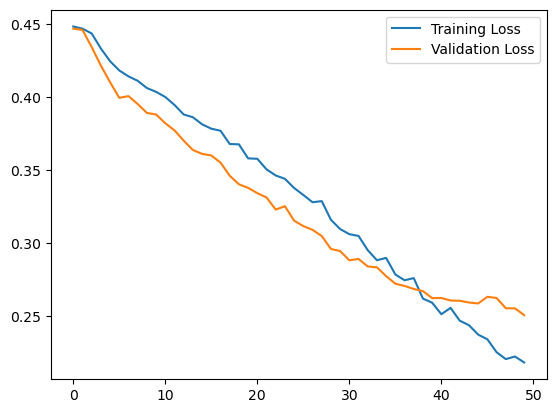

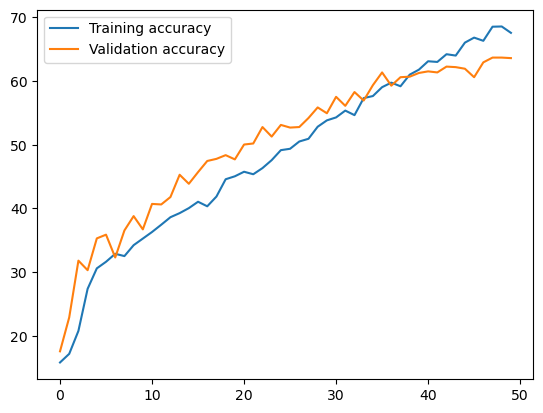

Training on cuda:0, Learning rate: 0.0001, Weight Decay: 0.001
Epoch [1/50]
-------------------------------
Training Loss: 0.4488, Accuracy: 16.2442 
Validation Loss: 0.4472, Accuracy: 17.5687

Validation Loss Decrease from 2.0000 to 0.4472 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4481, Accuracy: 16.9582 
Validation Loss: 0.4469, Accuracy: 17.5687

Validation Loss Decrease from 0.4472 to 0.4469 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4474, Accuracy: 18.1364 
Validation Loss: 0.4470, Accuracy: 24.1465
Epoch [4/50]
-------------------------------
Training Loss: 0.4465, Accuracy: 18.8504 
Validation Loss: 0.4459, Accuracy: 19.3172

Validation Loss Decrease from 0.4469 to 0.4459 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4451, Accuracy: 20.5284 
Validation Loss: 0.4436, Accuracy: 25.6453

Validation Loss Decrease from 0.4459 to 0.4436 	 Model is Saved

Epoch [6/50]
----------

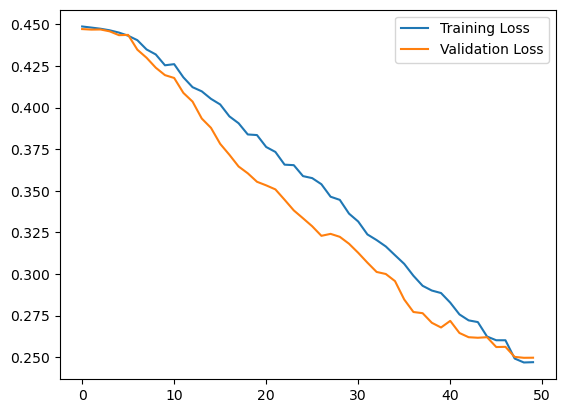

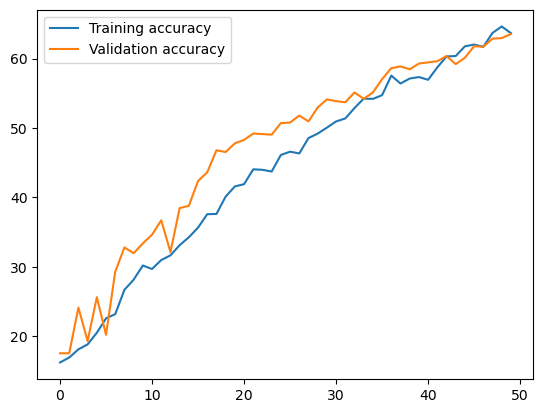

Training on cuda:0, Learning rate: 0.0005, Weight Decay: 0
Epoch [1/50]
-------------------------------
Training Loss: 0.4485, Accuracy: 17.7437 
Validation Loss: 0.4480, Accuracy: 15.2373

Validation Loss Decrease from 2.0000 to 0.4480 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4481, Accuracy: 17.8508 
Validation Loss: 0.4475, Accuracy: 17.5687

Validation Loss Decrease from 0.4480 to 0.4475 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4476, Accuracy: 17.7080 
Validation Loss: 0.4470, Accuracy: 17.5687

Validation Loss Decrease from 0.4475 to 0.4470 	 Model is Saved

Epoch [4/50]
-------------------------------
Training Loss: 0.4475, Accuracy: 17.4580 
Validation Loss: 0.4467, Accuracy: 23.6470

Validation Loss Decrease from 0.4470 to 0.4467 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4445, Accuracy: 20.9925 
Validation Loss: 0.4424, Accuracy: 27.7269

Validation Loss Decrease f

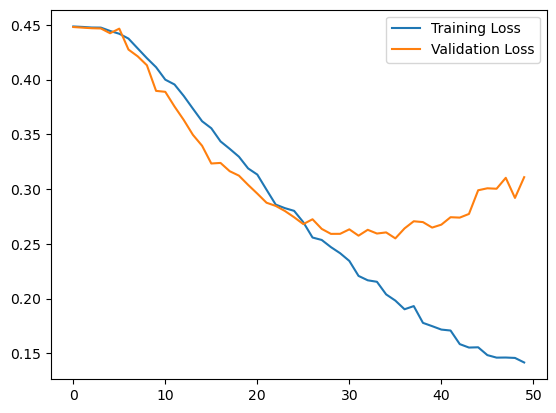

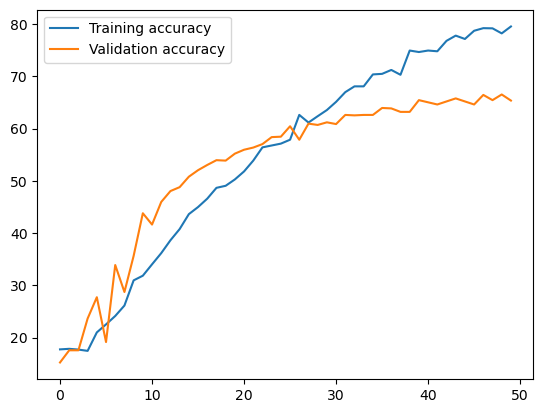

Training on cuda:0, Learning rate: 0.0005, Weight Decay: 0.0001
Epoch [1/50]
-------------------------------
Training Loss: 0.4486, Accuracy: 18.3863 
Validation Loss: 0.4473, Accuracy: 17.5687

Validation Loss Decrease from 2.0000 to 0.4473 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4481, Accuracy: 18.4577 
Validation Loss: 0.4465, Accuracy: 17.5687

Validation Loss Decrease from 0.4473 to 0.4465 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4476, Accuracy: 18.2435 
Validation Loss: 0.4472, Accuracy: 18.1515
Epoch [4/50]
-------------------------------
Training Loss: 0.4465, Accuracy: 19.2788 
Validation Loss: 0.4401, Accuracy: 27.8102

Validation Loss Decrease from 0.4465 to 0.4401 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4417, Accuracy: 23.0632 
Validation Loss: 0.4271, Accuracy: 30.5579

Validation Loss Decrease from 0.4401 to 0.4271 	 Model is Saved

Epoch [6/50]
---------

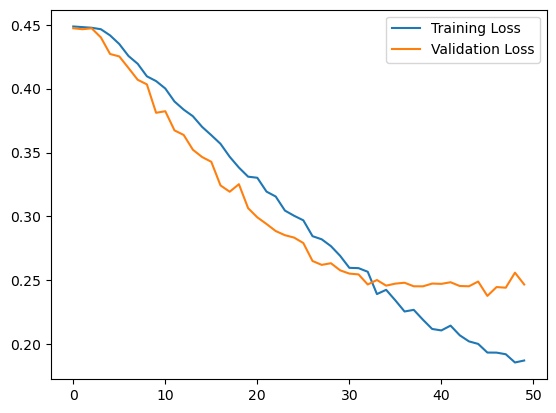

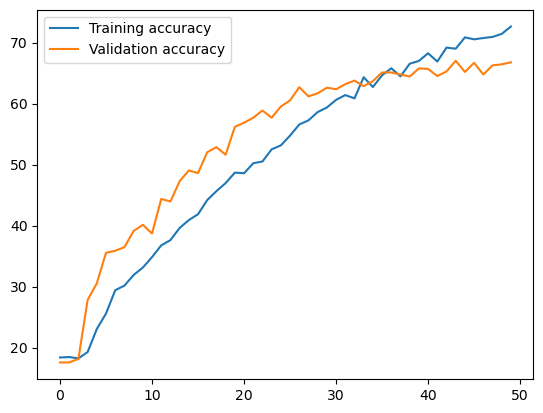

Training on cuda:0, Learning rate: 0.0005, Weight Decay: 0.0005
Epoch [1/50]
-------------------------------
Training Loss: 0.4491, Accuracy: 15.5659 
Validation Loss: 0.4475, Accuracy: 16.1532

Validation Loss Decrease from 2.0000 to 0.4475 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4480, Accuracy: 18.4220 
Validation Loss: 0.4456, Accuracy: 28.1432

Validation Loss Decrease from 0.4475 to 0.4456 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4456, Accuracy: 21.3495 
Validation Loss: 0.4412, Accuracy: 25.2290

Validation Loss Decrease from 0.4456 to 0.4412 	 Model is Saved

Epoch [4/50]
-------------------------------
Training Loss: 0.4369, Accuracy: 24.6698 
Validation Loss: 0.4213, Accuracy: 36.8027

Validation Loss Decrease from 0.4412 to 0.4213 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4300, Accuracy: 26.2406 
Validation Loss: 0.4149, Accuracy: 36.3031

Validation Loss Decre

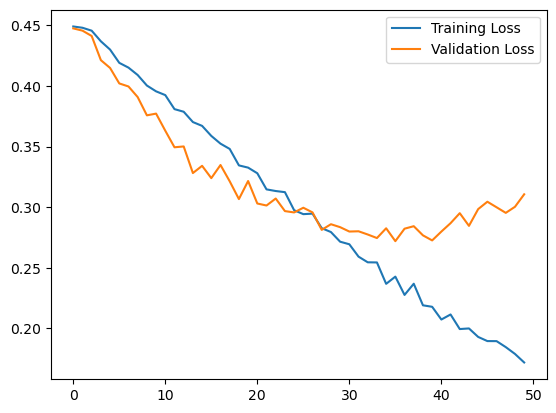

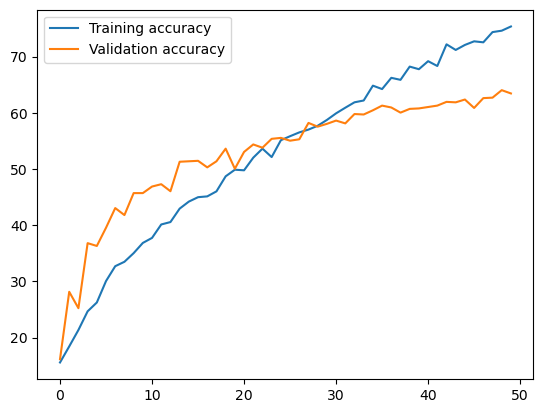

Training on cuda:0, Learning rate: 0.0005, Weight Decay: 0.001
Epoch [1/50]
-------------------------------
Training Loss: 0.4490, Accuracy: 17.3866 
Validation Loss: 0.4474, Accuracy: 17.5687

Validation Loss Decrease from 2.0000 to 0.4474 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 16.6726 
Validation Loss: 0.4485, Accuracy: 15.2373
Epoch [3/50]
-------------------------------
Training Loss: 0.4482, Accuracy: 15.6016 
Validation Loss: 0.4477, Accuracy: 19.8168
Epoch [4/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 17.4223 
Validation Loss: 0.4476, Accuracy: 17.5687
Epoch [5/50]
-------------------------------
Training Loss: 0.4478, Accuracy: 18.1721 
Validation Loss: 0.4478, Accuracy: 17.5687
Epoch [6/50]
-------------------------------
Training Loss: 0.4478, Accuracy: 18.0293 
Validation Loss: 0.4476, Accuracy: 17.5687
Epoch [7/50]
-------------------------------
Training Loss: 0.4478, Accuracy: 17.4223 
Vali

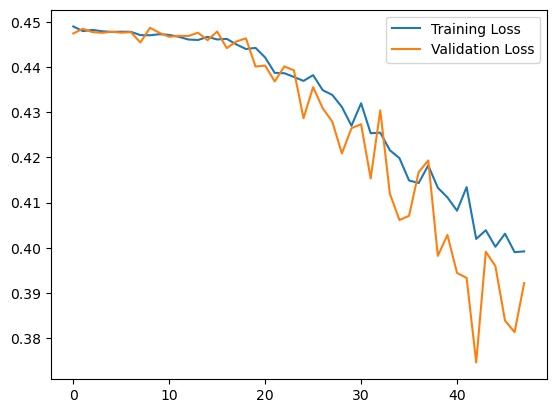

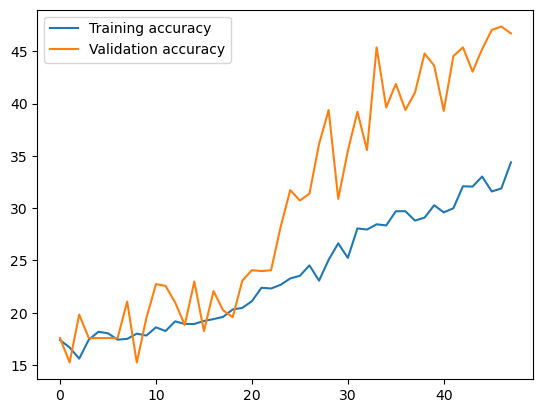

Training on cuda:0, Learning rate: 0.001, Weight Decay: 0
Epoch [1/50]
-------------------------------
Training Loss: 0.4491, Accuracy: 17.6366 
Validation Loss: 0.4479, Accuracy: 17.5687

Validation Loss Decrease from 2.0000 to 0.4479 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4481, Accuracy: 17.6009 
Validation Loss: 0.4478, Accuracy: 17.5687

Validation Loss Decrease from 0.4479 to 0.4478 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4480, Accuracy: 17.4223 
Validation Loss: 0.4477, Accuracy: 17.5687

Validation Loss Decrease from 0.4478 to 0.4477 	 Model is Saved

Epoch [4/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 17.7794 
Validation Loss: 0.4478, Accuracy: 17.4854
Epoch [5/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 17.1010 
Validation Loss: 0.4477, Accuracy: 17.5687

Validation Loss Decrease from 0.4477 to 0.4477 	 Model is Saved

Epoch [6/50]
---------------

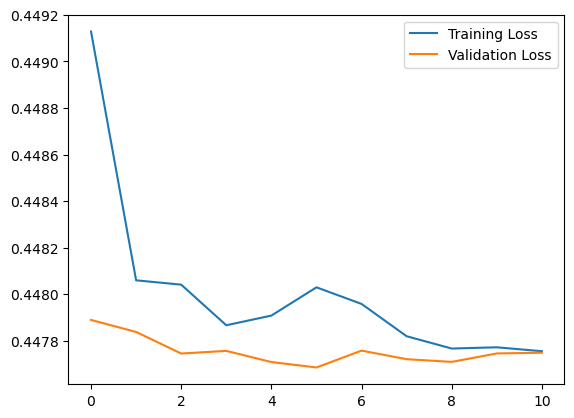

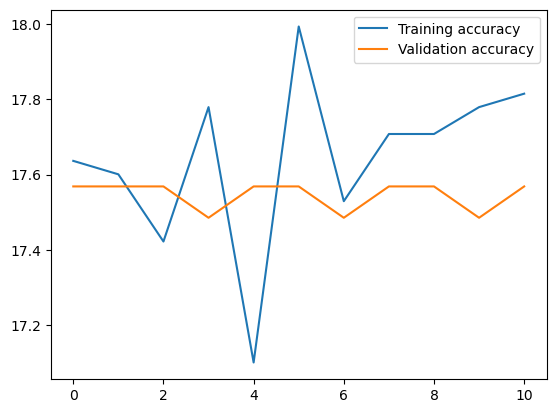

Training on cuda:0, Learning rate: 0.001, Weight Decay: 0.0001
Epoch [1/50]
-------------------------------
Training Loss: 0.4491, Accuracy: 17.8865 
Validation Loss: 0.4474, Accuracy: 17.4854

Validation Loss Decrease from 2.0000 to 0.4474 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4482, Accuracy: 16.2085 
Validation Loss: 0.4477, Accuracy: 17.5687
Epoch [3/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 17.6723 
Validation Loss: 0.4477, Accuracy: 17.5687
Epoch [4/50]
-------------------------------
Training Loss: 0.4477, Accuracy: 18.2078 
Validation Loss: 0.4469, Accuracy: 18.9842

Validation Loss Decrease from 0.4474 to 0.4469 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4439, Accuracy: 20.1000 
Validation Loss: 0.4313, Accuracy: 26.8110

Validation Loss Decrease from 0.4469 to 0.4313 	 Model is Saved

Epoch [6/50]
-------------------------------
Training Loss: 0.4393, Accuracy: 22.9918 
Va

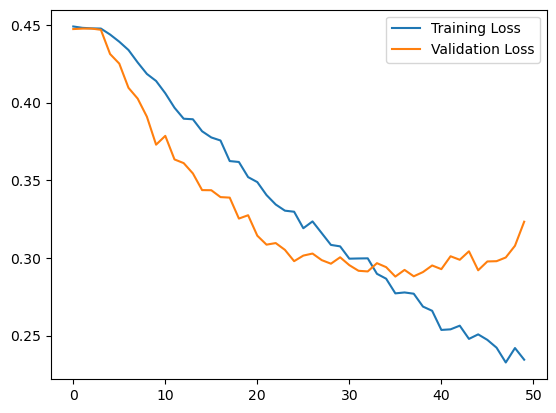

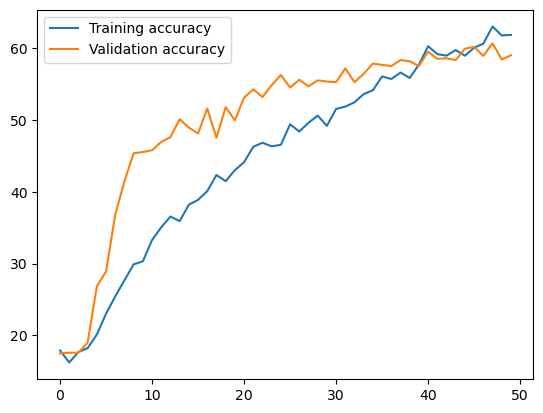

Training on cuda:0, Learning rate: 0.001, Weight Decay: 0.0005
Epoch [1/50]
-------------------------------
Training Loss: 0.4492, Accuracy: 16.4584 
Validation Loss: 0.4476, Accuracy: 17.4854

Validation Loss Decrease from 2.0000 to 0.4476 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 17.8151 
Validation Loss: 0.4478, Accuracy: 17.5687
Epoch [3/50]
-------------------------------
Training Loss: 0.4478, Accuracy: 17.6366 
Validation Loss: 0.4473, Accuracy: 17.5687

Validation Loss Decrease from 0.4476 to 0.4473 	 Model is Saved

Epoch [4/50]
-------------------------------
Training Loss: 0.4469, Accuracy: 18.2078 
Validation Loss: 0.4458, Accuracy: 19.7336

Validation Loss Decrease from 0.4473 to 0.4458 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4426, Accuracy: 20.3499 
Validation Loss: 0.4381, Accuracy: 23.4804

Validation Loss Decrease from 0.4458 to 0.4381 	 Model is Saved

Epoch [6/50]
----------

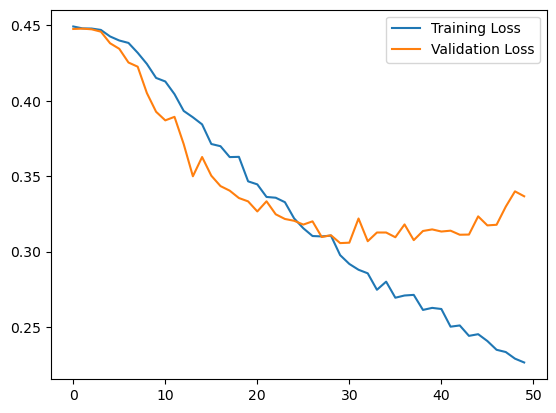

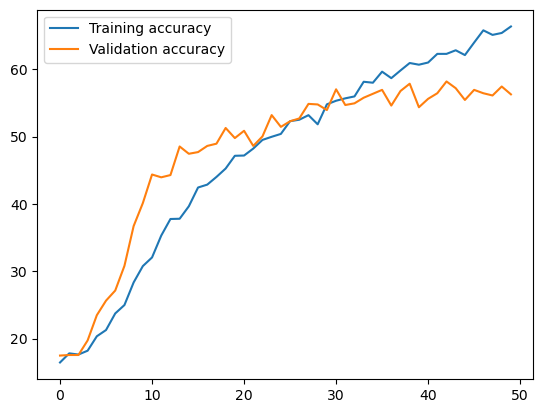

Training on cuda:0, Learning rate: 0.001, Weight Decay: 0.001
Epoch [1/50]
-------------------------------
Training Loss: 0.4489, Accuracy: 16.2085 
Validation Loss: 0.4476, Accuracy: 17.4022

Validation Loss Decrease from 2.0000 to 0.4476 	 Model is Saved

Epoch [2/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 16.6726 
Validation Loss: 0.4476, Accuracy: 17.5687

Validation Loss Decrease from 0.4476 to 0.4476 	 Model is Saved

Epoch [3/50]
-------------------------------
Training Loss: 0.4479, Accuracy: 17.2795 
Validation Loss: 0.4476, Accuracy: 17.5687

Validation Loss Decrease from 0.4476 to 0.4476 	 Model is Saved

Epoch [4/50]
-------------------------------
Training Loss: 0.4478, Accuracy: 17.3509 
Validation Loss: 0.4468, Accuracy: 18.7344

Validation Loss Decrease from 0.4476 to 0.4468 	 Model is Saved

Epoch [5/50]
-------------------------------
Training Loss: 0.4470, Accuracy: 17.9222 
Validation Loss: 0.4447, Accuracy: 22.0649

Validation Loss Decreas

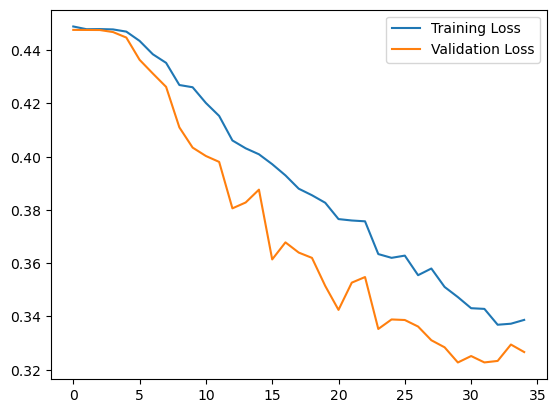

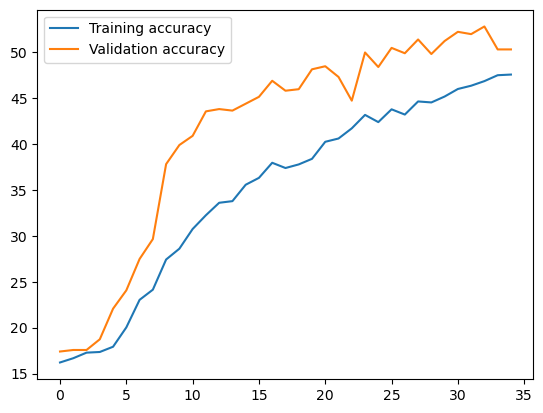

In [43]:
best_loss = 2.0
best_acc = 0.0

# List for hyperparameter tuning
lr_tuple = [1e-4, 5e-4, 1e-3]
decay_tuple = [0, 1e-4, 5e-4, 1e-3]
val_loss_lst = []
val_acc_lst = []

for learning_rate in lr_tuple:
    val_loss = []
    val_acc = []
    for weight_decay in decay_tuple:
        
        print(f'Training on {device}, Learning rate: {learning_rate}, Weight Decay: {weight_decay}')
        model = Net().to(device)
        adam = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
        current_model, current_acc, current_loss, current_loss_history, current_acc_history = train_with_val(model, criterion, optimizer=adam, num_epochs=50)
        val_loss.append(current_loss_history)
        val_acc.append(current_acc_history)
            
        # If current validation accuracy is better than best accuracy
        if current_loss < best_loss:
            best_loss = current_loss
            best_model = current_model
            best_params = {'learning_rate': learning_rate, 'Weight Decay': weight_decay} # Save the best hyperparameters
            
        # Update best accuracy
        if current_acc > best_acc:
            best_acc = current_acc
    
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)

# Save the best model
PATH = './handgesturedigit.pth'
torch.save(best_model.state_dict(), PATH)
    

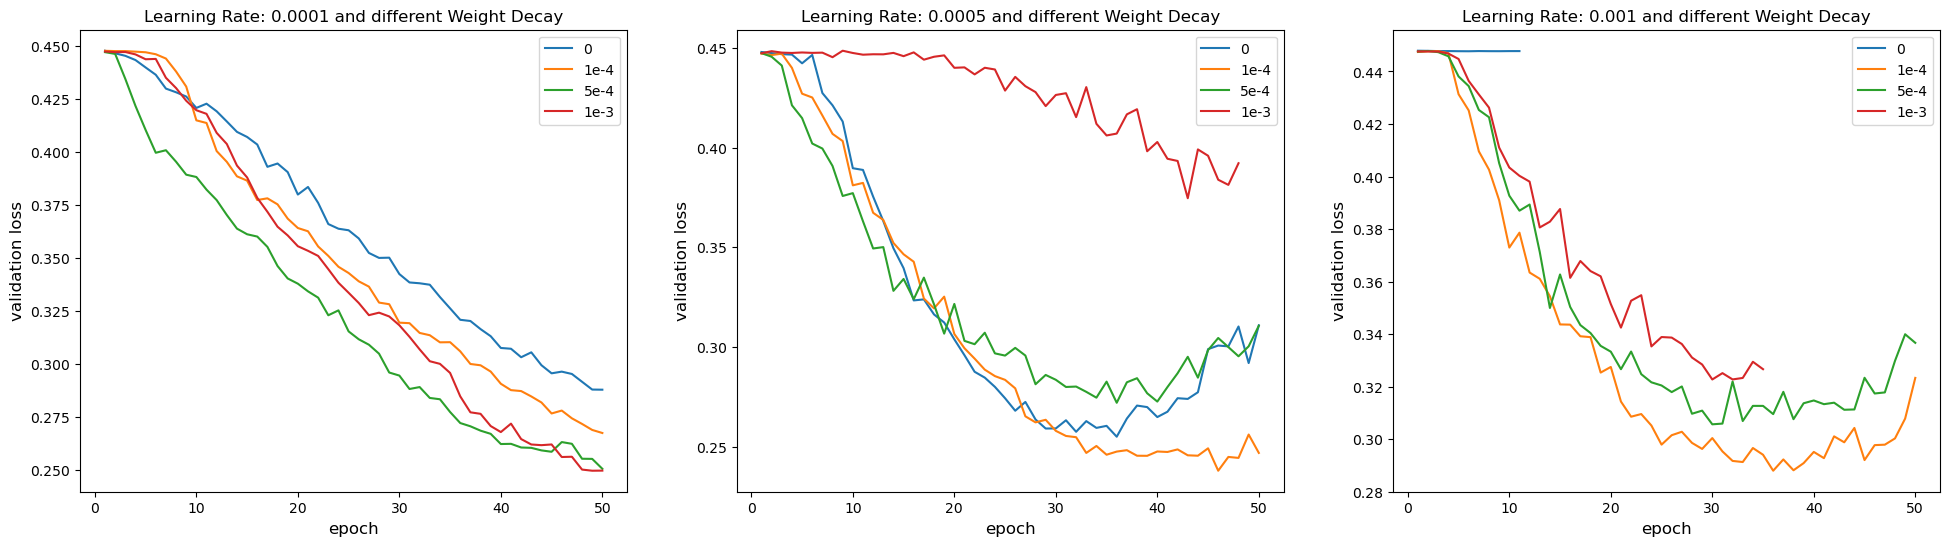

In [92]:
# Plot the validation loss result from hyperparameter tuning 
_, ax = plt.subplots(1,3, figsize = (24,6))

for i, weight_decay_rate in ((0, '0'),(1, '1e-4'),(2, '5e-4'),(3, '1e-3')):
    ax[0].plot(range(1, len(val_loss_lst[0][i])+1), val_loss_lst[0][i], label = weight_decay_rate)
ax[0].set_title('Learning Rate: 0.0001 and different Weight Decay')
ax[0].set_xlabel('epoch', fontsize = 12)
ax[0].set_ylabel('validation loss', fontsize = 12)
ax[0].legend()

for i, weight_decay_rate in ((0, '0'),(1, '1e-4'),(2, '5e-4'),(3, '1e-3')):
    ax[1].plot(range(1, len(val_loss_lst[1][i])+1), val_loss_lst[1][i], label = weight_decay_rate)
ax[1].set_title('Learning Rate: 0.0005 and different Weight Decay')
ax[1].set_xlabel('epoch', fontsize = 12)
ax[1].set_ylabel('validation loss', fontsize = 12)
ax[1].legend()

for i, weight_decay_rate in ((0, '0'),(1, '1e-4'),(2, '5e-4'),(3, '1e-3')):
    ax[2].plot(range(1, len(val_loss_lst[2][i])+1), val_loss_lst[2][i], label = weight_decay_rate)
ax[2].set_title('Learning Rate: 0.001 and different Weight Decay')
ax[2].set_xlabel('epoch', fontsize = 12)
ax[2].set_ylabel('validation loss', fontsize = 12)
ax[2].legend()

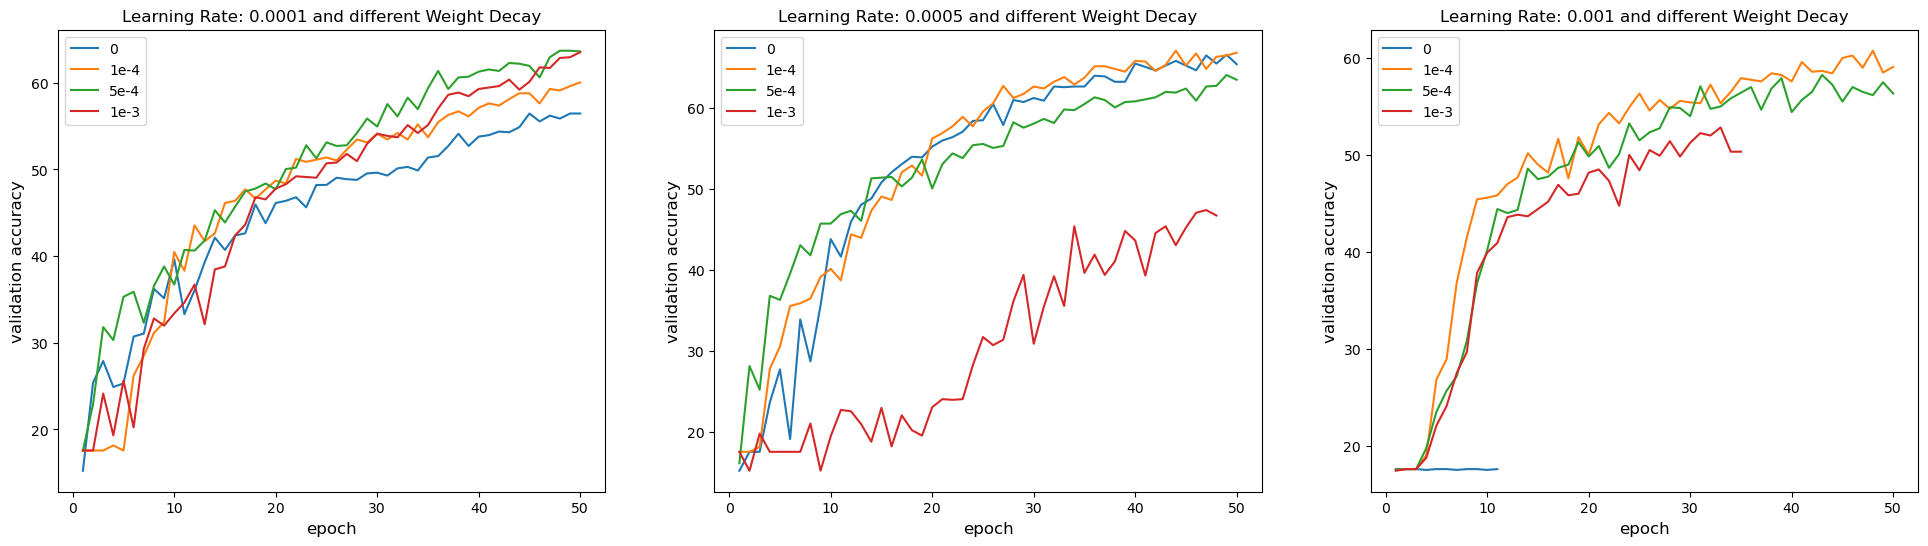

In [93]:
# Plot the validation accuracy result from hyperparameter tuning
_, ax = plt.subplots(1,3, figsize = (24,6))

for i, weight_decay_rate in ((0, '0'),(1, '1e-4'),(2, '5e-4'),(3, '1e-3')):
    ax[0].plot(range(1, len(val_acc_lst[0][i])+1), val_acc_lst[0][i], label = weight_decay_rate)
ax[0].set_title('Learning Rate: 0.0001 and different Weight Decay')
ax[0].set_xlabel('epoch', fontsize = 12)
ax[0].set_ylabel('validation accuracy', fontsize = 12)
ax[0].legend()

for i, weight_decay_rate in ((0, '0'),(1, '1e-4'),(2, '5e-4'),(3, '1e-3')):
    ax[1].plot(range(1, len(val_acc_lst[1][i])+1), val_acc_lst[1][i], label = weight_decay_rate)
ax[1].set_title('Learning Rate: 0.0005 and different Weight Decay')
ax[1].set_xlabel('epoch', fontsize = 12)
ax[1].set_ylabel('validation accuracy', fontsize = 12)
ax[1].legend()

for i, weight_decay_rate in ((0, '0'),(1, '1e-4'),(2, '5e-4'),(3, '1e-3')):
    ax[2].plot(range(1, len(val_acc_lst[2][i])+1), val_acc_lst[2][i], label = weight_decay_rate)
ax[2].set_title('Learning Rate: 0.001 and different Weight Decay')
ax[2].set_xlabel('epoch', fontsize = 12)
ax[2].set_ylabel('validation accuracy', fontsize = 12)
ax[2].legend()

In [44]:
# Check the best hyperparameters
print("Best parameters for CNN Model: ", best_params)
print(f"Validation Loss of Best Parameters: {best_loss}")
print(f"Best Validation Accuracy: {best_acc:.2f}%")

Best parameters for CNN Model:  {'learning_rate': 0.0005, 'Weight Decay': 0.0001}
Validation Loss of Best Parameters: 0.23787620233497478
Best Validation Accuracy: 67.03%


<a id = "Model_Testing"></a>
### ► Model Testing

In [60]:
# Load model 
PATH = './handgesturedigit.pth'
model = Net()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [61]:
if torch.cuda.is_available():
    model.cuda()

In [80]:
batch_size = 4
with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        
        _, predicted = torch.max(output, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum()
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test dataset: {acc} %')

Accuracy of the network on test dataset: 56.087825775146484 %


Based on the result, we can see that our network did not performed well on classifying our dataset. Besides, there is also problem of overfitting occured on the training process during very early epoch.

<a id = "Experiment1"></a>
### ► Experiment Using Pretrained Network (ResNet18)

Since our model network did not classify our dataset well, we tend to conduct an experiment using Pretrained Network on our dataset in order to investigate whether the deep learning model can learn our dataset well. The pretrained network to be used in this experiment is ResNet18.

In [84]:
# Clear cache memory before proceed
torch.cuda.empty_cache()

In [85]:
model_ft = models.resnet18(pretrained=True)

c:\Users\yijin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\yijin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 6)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0005, weight_decay = 0.0001) # using best hyperparameter from previous hyperparameter tuning

Epoch [1/30]
-------------------------------
Training Loss: 0.3359, Accuracy: 49.5894 
Validation Loss: 0.2564, Accuracy: 61.4488

Validation Loss Decrease from 2.0000 to 0.2564 	 Model is Saved

Epoch [2/30]
-------------------------------
Training Loss: 0.2287, Accuracy: 66.5834 
Validation Loss: 0.2410, Accuracy: 61.6986

Validation Loss Decrease from 0.2564 to 0.2410 	 Model is Saved

Epoch [3/30]
-------------------------------
Training Loss: 0.1774, Accuracy: 74.7590 
Validation Loss: 0.1550, Accuracy: 77.2689

Validation Loss Decrease from 0.2410 to 0.1550 	 Model is Saved

Epoch [4/30]
-------------------------------
Training Loss: 0.1507, Accuracy: 78.5791 
Validation Loss: 0.1667, Accuracy: 77.5187
Epoch [5/30]
-------------------------------
Training Loss: 0.1229, Accuracy: 82.6133 
Validation Loss: 0.1569, Accuracy: 76.9359
Epoch [6/30]
-------------------------------
Training Loss: 0.0986, Accuracy: 87.0046 
Validation Loss: 0.1612, Accuracy: 76.9359
Epoch [7/30]
---------

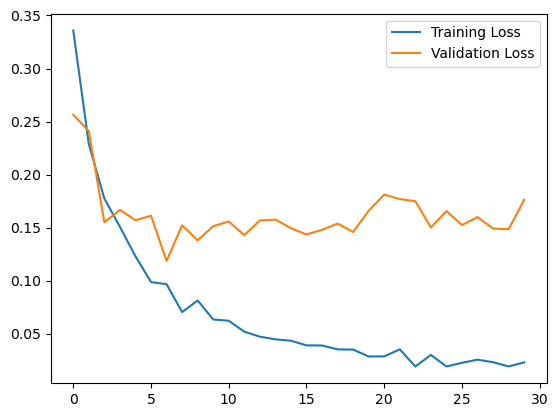

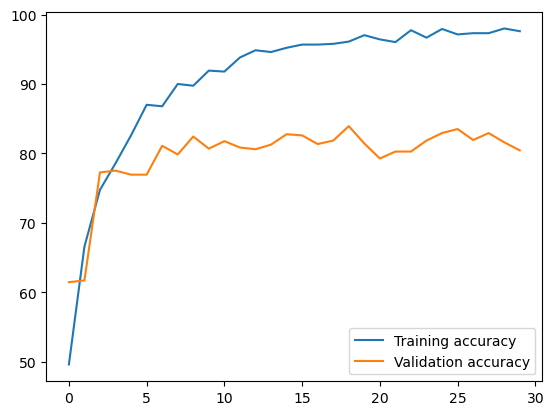

In [87]:
res_model, res_acc, res_loss, res_loss_histoy, res_acc_history = train_with_val(model_ft, criterion, optimizer=optimizer, num_epochs=30)

In [88]:
# Check validation result of ResNet18
print(f'Best Validation loss of ResNet18 Network:', res_loss)
print(f'Best Validation accuracy of ResNet18 Network:', res_acc)

Best Validation loss of ResNet18 Network: 0.11854061684249392
Best Validation accuracy of ResNet18 Network: 83.93006134033203


In [89]:
batch_size = 4
with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = res_model(images)
        
        _, predicted = torch.max(output, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum()
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test dataset: {acc} %')

Accuracy of the network on test dataset: 81.2375259399414 %


Based on the experiment result, the result of pretrained ResNet18 network can train our dataset well. Thus, we will try to rebuild our network architecture.

We will build a network with larger channels in the concolutional layer. This is because the output channels in the ResNet18 Network is way latger than our current network, and thus we **came out with a hypothesis that larger channels in the concolutional layer will help improve our classification task**.

Besides, we will also included **BatchNorm Layer** in our new network to see whether it can helped improve the network performance.

<a id = "Rebuild Network"></a>
### ► Rebuild Network

In [97]:
class Net2(nn.Module):
    
    def __init__(self, num_classes = 6):
        
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.drop = nn.Dropout2d(p = 0.5)
        self.fc1 = nn.Linear(in_features = 64 * 10 * 10, out_features = 120)
        self.fc1_bn = nn.BatchNorm1d(num_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = num_classes)
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv1_bn(x)
        x = self.pool(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = self.conv2_bn(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv3_bn(x)
        x = self.pool(x)
        x = self.drop(x)
        x = x.view(-1, 64 * 10 * 10)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [98]:
model = Net2().to(device)
summary(model, (3, 80, 80))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 80, 80]             448
       BatchNorm2d-2           [-1, 16, 80, 80]              32
         MaxPool2d-3           [-1, 16, 40, 40]               0
         Dropout2d-4           [-1, 16, 40, 40]               0
            Conv2d-5           [-1, 32, 40, 40]           4,640
         MaxPool2d-6           [-1, 32, 20, 20]               0
         Dropout2d-7           [-1, 32, 20, 20]               0
       BatchNorm2d-8           [-1, 32, 20, 20]              64
            Conv2d-9           [-1, 64, 20, 20]          18,496
      BatchNorm2d-10           [-1, 64, 20, 20]             128
        MaxPool2d-11           [-1, 64, 10, 10]               0
        Dropout2d-12           [-1, 64, 10, 10]               0
           Linear-13                  [-1, 120]         768,120
      BatchNorm1d-14                  [

Epoch [1/100]
-------------------------------
Training Loss: 0.4411, Accuracy: 24.7412 
Validation Loss: 0.3925, Accuracy: 37.2190

Validation Loss Decrease from 2.0000 to 0.3925 	 Model is Saved

Epoch [2/100]
-------------------------------
Training Loss: 0.4112, Accuracy: 31.5602 
Validation Loss: 0.3732, Accuracy: 45.2956

Validation Loss Decrease from 0.3925 to 0.3732 	 Model is Saved

Epoch [3/100]
-------------------------------
Training Loss: 0.4007, Accuracy: 36.0943 
Validation Loss: 0.3647, Accuracy: 45.3788

Validation Loss Decrease from 0.3732 to 0.3647 	 Model is Saved

Epoch [4/100]
-------------------------------
Training Loss: 0.3930, Accuracy: 37.1653 
Validation Loss: 0.3486, Accuracy: 49.1257

Validation Loss Decrease from 0.3647 to 0.3486 	 Model is Saved

Epoch [5/100]
-------------------------------
Training Loss: 0.3843, Accuracy: 39.4145 
Validation Loss: 0.3446, Accuracy: 49.3755

Validation Loss Decrease from 0.3486 to 0.3446 	 Model is Saved

Epoch [6/100]
-

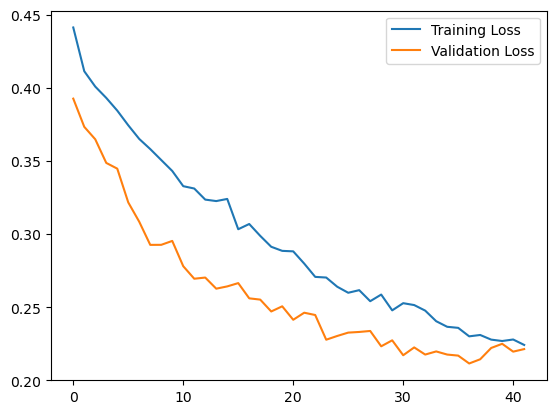

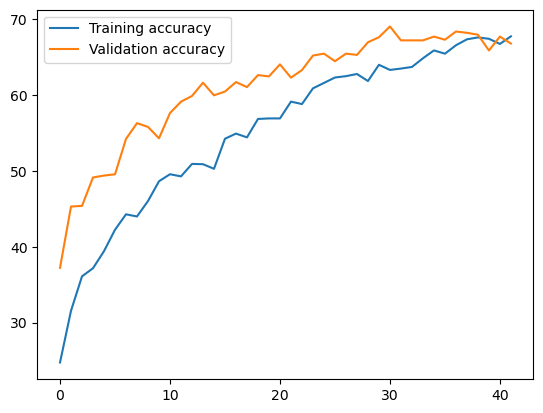

In [99]:
criterion = nn.CrossEntropyLoss()
model = Net2().to(device)
adam = optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 0.0001)      
model, acc, loss, loss_history, acc_history = train_with_val(model, criterion, optimizer=adam, num_epochs=100)

In [100]:
# Check validation result of ResNet18
print(f'Best Validation loss of Rebuild Network: {loss}')

Best Validation loss of Rebuild Network: 0.21144343988906333


In [104]:
batch_size = 4
with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        
        _, predicted = torch.max(output, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum()
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test dataset: {acc} %')

Accuracy of the network on test dataset: 65.8682632446289 %


Based on this experiment, we can see that the rebuild model performance a significant improvement, sometimes it will have more improvement that we will get validation loss od 0.17. The reason of this will be explained in the report.

Therefore, this rebuild network will be our final deep learning model for our project.

The performance can be improved when we added more convolutional layer, and also increase the number of channels in the convolutional layer; however, this will increase the computation time and the memory. We have faced a hadrware shortage when we added more layers, as our model parameters is very large but our Cuda has only 4GB. Thus, for future works, when we have better hardware, we can try adding more layers.

<a id = "Experiment2"></a>
### ► Experiment Using Dataset with Two Classes (0 and 1)

Another suspected reason of low accuracy on our dataset classification is that our dataset consists of too many classes, and each classes have similar mutual features among each other. Therefore, we will conduct another experiment using a dataset consisting of just 2 classes, which is class 0 and 1. The model network used here is the model we built. 

In [105]:
# Load image data
Images1 = []
Labels1 = []

# Visualize some examples of resize image
for i in glob.glob(r"ExperimentDataset\*"):
    imagei = io.imread(i)
    image_resized = resize(imagei, output_shape = (80, 80)) # resize image to shape of (80,80)
    Images1.append(image_resized)
    Labels1.append(int(os.path.basename(i).split("_")[0])) # get labels from filename

In [195]:
# Convert images and labels to array 
D1 = np.array(Images1).astype('float32')
D1 = normalize_images(D1) # Normalize image data
y1 = np.array(Labels1).astype('float32')

In [196]:
# split data into train and test set
X, x_test, Y, y_test = train_test_split(D1, y1, test_size = 0.2, shuffle = True)
print("After seperate to 80% training and 20% test, X_train have shape",X.shape,"y_train have shape",Y.shape)
print("                                             X_test  have shape",x_test.shape,"y_test have shape",y_test.shape)

After seperate to 80% training and 20% test, X_train have shape (79, 80, 80, 3) y_train have shape (79,)
                                             X_test  have shape (20, 80, 80, 3) y_test have shape (20,)


In [197]:
# Data augmentation (image augmentation on training dataset)
# Generate 4 augmented images for each 1664 images in training dataset
train_data = []
target_train = []

for i in tqdm(range(X.shape[0])):
    train_data.append(X[i]) # Original image
    # Randomly choose 1 option to augment the data, we do augmentation only once on every image
    a = np.random.randint(0,4)
    if a == 0:
        train_data.append(rotate(X[i], angle = 15, mode = 'wrap')) # Rotate the image by 15 degrees
    elif a == 1:
        train_data.append(np.fliplr(X[i])) # Flip image in left-right direction
    elif a == 2:
        train_data.append(np.flipud(X[i])) # Flip image in up-down direction
    elif a == 3:
        train_data.append(random_noise(X[i], var = 0.2 ** 2)) # Add random noise to the floating-point image
    
    for j in range(2):
        target_train.append(Y[i]) # Label the augmented images

100%|██████████| 79/79 [00:00<00:00, 2136.58it/s]


In [198]:
# Convert images and labels to array
train_data = np.array(train_data).astype('float32')
target_train = np.array(target_train).astype(int)

In [199]:
gaussian_blured = []
for i in tqdm(range(train_data.shape[0])):
    gaussian_blured.append(cv2.GaussianBlur(train_data[i], (3,3), 0))

100%|██████████| 158/158 [00:00<00:00, 39519.35it/s]


In [200]:
train_data = np.array(gaussian_blured).astype('float32')

In [201]:
# Split train_data to training data and validation data
x_train, x_valid, y_train, y_valid = train_test_split(train_data, target_train, test_size = 0.2, shuffle = True)
print("After seperate to 80% training and 20% validation, X_train have shape",x_train.shape,"y_train have shape",y_train.shape)
print("                                                   X_valid have shape",x_valid.shape,"y_valid have shape",y_valid.shape)

After seperate to 80% training and 20% validation, X_train have shape (126, 80, 80, 3) y_train have shape (126,)
                                                   X_valid have shape (32, 80, 80, 3) y_valid have shape (32,)


In [202]:
# Transpose the data from shape (80,80,3) to (3,80,80)
temp = []
for i in tqdm(range(x_train.shape[0])):
    temp.append(x_train[i].T)

# Convert data to numpy array
x_train = np.array(temp)

100%|██████████| 126/126 [00:00<00:00, 603979.78it/s]


In [203]:
# Transpose the data from shape (80,80,3) to (3,80,80)
temp = []
for i in tqdm(range(x_valid.shape[0])):
    temp.append(x_valid[i].T)

# COnvert data to numpy array
x_valid = np.array(temp)

100%|██████████| 32/32 [00:00<?, ?it/s]


In [204]:
gaussian_blured = []
for i in tqdm(range(x_test.shape[0])):
    gaussian_blured.append(cv2.GaussianBlur(x_test[i], (3,3), 0))

# Convert test dataset to numpy array
x_test = np.array(gaussian_blured).astype('float32')

# Transpose the data from shape (80,80,3) to (3,80,80)
temp = []
for i in tqdm(range(x_test.shape[0])):
    temp.append(x_test[i].T)
    
# Convert data to numpy array
x_test = np.array(temp).astype('float32')

# Check shape of test dataset after denoising using gaussian low pass filter
print("After performing gaussian filter, the shape of test dataset is:", x_test.shape)

100%|██████████| 20/20 [00:00<?, ?it/s]

After performing gaussian filter, the shape of test dataset is: (20, 3, 80, 80)


In [205]:
# Convert train, validation, and test dataset into pyTorch format

# Converting train dataset into torch format
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
y_train = y_train.long()

# Converting validation dataset into torch format
x_valid = torch.from_numpy(x_valid)
y_valid = torch.from_numpy(y_valid)
y_valid = y_valid.long()

# Converting test dataset into torch format
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)
y_test = y_test.long()

In [206]:
# Fit data into torch dataset
train_dataset = TensorDataset(x_train, y_train)
validation_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

In [207]:
# DataLoader
train_loader = DataLoader(dataset = train_dataset, batch_size = 4, shuffle = True, drop_last = True)
validation_loader = DataLoader(dataset = validation_dataset, batch_size = 4, shuffle = True, drop_last = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = 4, shuffle = True, drop_last = True)

In [259]:
class ExperimentNet(nn.Module):
    
    def __init__(self, num_classes = 2):
        
        super(ExperimentNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, stride = 1, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.drop = nn.Dropout2d(p = 0.5)
        self.fc1 = nn.Linear(in_features = 64 * 10 * 10, out_features = 120)
        self.fc1_bn = nn.BatchNorm1d(num_features = 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = num_classes)
        
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv1_bn(x)
        x = self.pool(x)
        x = self.drop(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop(x)
        x = self.conv2_bn(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv3_bn(x)
        x = self.pool(x)
        x = self.drop(x)
        x = x.view(-1, 64 * 10 * 10)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

Epoch [1/100]
-------------------------------
Training Loss: 0.1833, Accuracy: 53.9683 
Validation Loss: 0.1775, Accuracy: 40.6250

Validation Loss Decrease from 2.0000 to 0.1775 	 Model is Saved

Epoch [2/100]
-------------------------------
Training Loss: 0.1881, Accuracy: 42.8571 
Validation Loss: 0.1881, Accuracy: 40.6250
Epoch [3/100]
-------------------------------
Training Loss: 0.1856, Accuracy: 47.6190 
Validation Loss: 0.1841, Accuracy: 40.6250
Epoch [4/100]
-------------------------------
Training Loss: 0.1865, Accuracy: 44.4444 
Validation Loss: 0.1844, Accuracy: 40.6250
Epoch [5/100]
-------------------------------
Training Loss: 0.1839, Accuracy: 50.7937 
Validation Loss: 0.1856, Accuracy: 40.6250
Epoch [6/100]
-------------------------------
Training Loss: 0.1818, Accuracy: 45.2381 
Validation Loss: 0.1867, Accuracy: 40.6250
Epoch [7/100]
-------------------------------
Training Loss: 0.1816, Accuracy: 48.4127 
Validation Loss: 0.1822, Accuracy: 40.6250
Epoch [8/100]
---

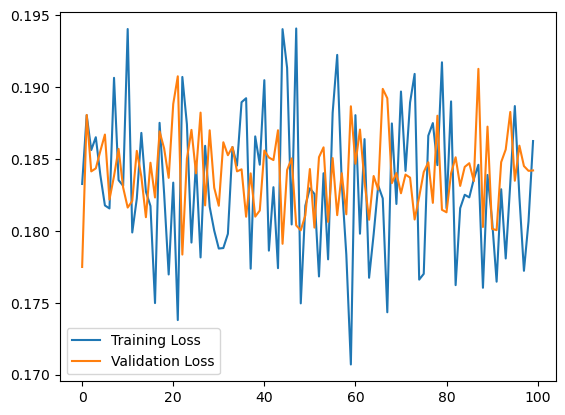

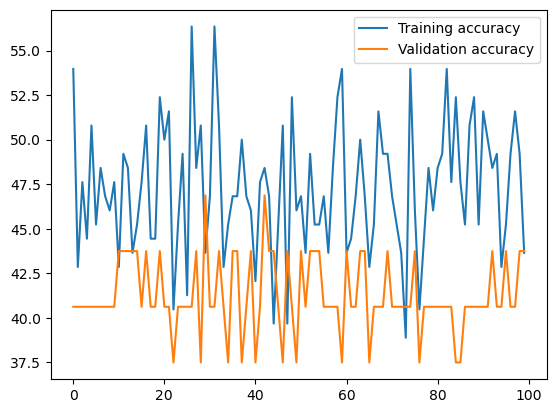

In [262]:
exp_model = ExperimentNet().to(device)
critirion = nn.CrossEntropyLoss()
adam = optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 0.0001) # using best hyperparameter combination
experiment_model, experiment_acc, experiment_loss, experiment_loss_history, experiment_acc_history = train_with_val(exp_model, criterion, optimizer = adam, num_epochs = 100)

In [265]:
print(f"Best Validation Loss: {experiment_loss}")

Best Validation Loss: 0.17749967984855175


In [266]:
batch_size = 4
with torch.no_grad():
    
    n_correct = 0
    n_samples = 0
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        output = experiment_model(images)
        
        _, predicted = torch.max(output, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum()
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on test dataset: {acc} %')

Accuracy of the network on test dataset: 70.0 %


For this experiment, although the validation accuracy and loss seems improved compared to dataset with 6 classes, the testing accuracy did improve. This shows that the reason of low accuracy of this project might be because of the number of classes for our dataset is too much, which causes the model cannot have a precise classification.

# </a><div style="text-align: center"> ~ THE END ~</a> </div>